In [1]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

In [2]:
def read_data_map(file,remove_baseline=False):

    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
    
    new_specs = []
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y

In [3]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [4]:
file = r"C:/Users/tomas/Desktop/Tomás/LIBS/FFT_multi/example_map"

spectrum, wavelengths, positions, unique_x, unique_y = read_data_map(file)

(170, 120, 16384)


In [5]:
spe = spectrum.reshape(spectrum.shape[0]*spectrum.shape[1], -1)
norm = np.array([gaussian_filter(spe[i, :]/np.sum(spe[i, :]), sigma = 0) for i in range(0, spe.shape[0])]).reshape(spectrum.shape)

In [24]:
norm_for_pca = norm.reshape(norm.shape[0]*norm.shape[1], -1)
norm_for_pca.shape

(20400, 16384)

In [45]:
scaled_pro = np.array([ gaussian_filter((norm[:, :, wv] - norm[:, :, wv].min())/(norm[:, :, wv].max() - norm[ :, :, wv].min()), sigma = 0)
                        for wv in range(norm.shape[-1])])

In [44]:
scaled_for_pca = scaled_pro.reshape(scaled_pro.shape[0], -1).T
scaled_for_pca.shape

(20400, 16384)

# Decomposition

### Test for the number of components

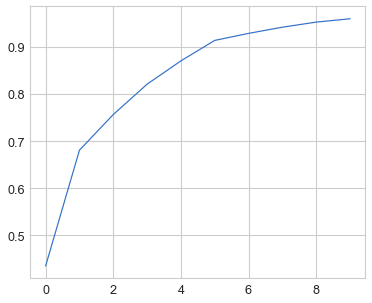

In [25]:
model = sklearn.decomposition.PCA(n_components = 10)
model.fit(norm_for_pca)

fig, ax = subplots(figsize = (6, 5))
ax.plot(np.cumsum(model.explained_variance_ratio_)) # above 5 components more than 95% of the variance is explained

### Decompose LIBS dataset

In [26]:
model_basis = sklearn.decomposition.PCA(n_components = 6)
model_basis.fit(norm_for_pca)

In [27]:
principal_components = model_basis.fit_transform(norm_for_pca)
weigths = model_basis.components_

In [28]:
principal_components.shape

(20400, 6)

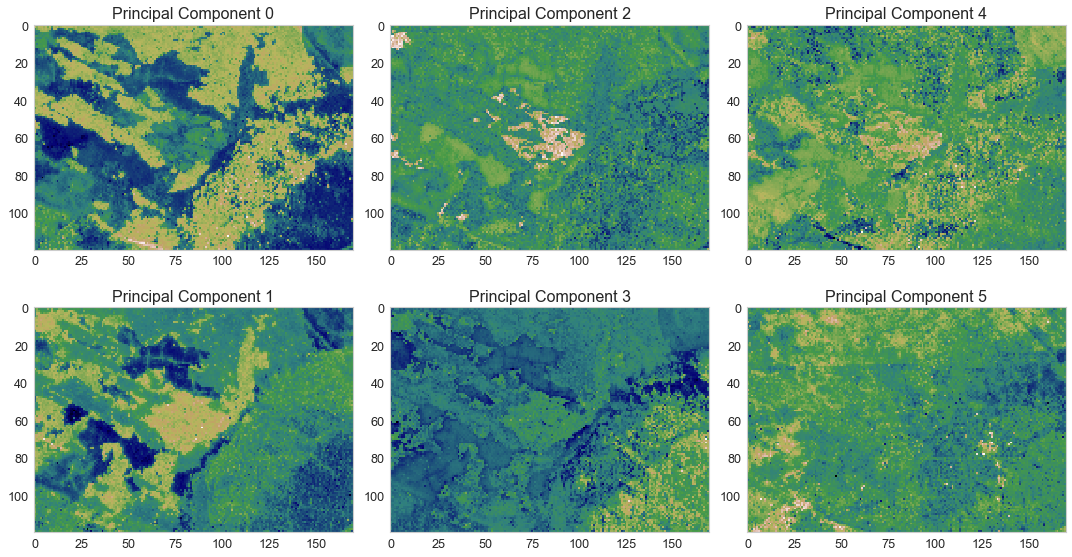

In [37]:
principal_images = principal_components.reshape(spectrum.shape[0], spectrum.shape[1], principal_components.shape[-1])

fig, ax = subplots(2, 3, figsize = (15, 8))

h, v = 0, 0

for i in range(principal_components.shape[-1]):
    axs = ax[h, v]
    axs.imshow(principal_images[:, :, i].T, cmap = 'gist_earth', interpolation = 'nearest')
    axs.set_title(f'Principal Component {i}', fontsize = 16)
    axs.grid(False)
    
    h += 1
    if h == 2:
        v +=1
        h = 0

fig.tight_layout()

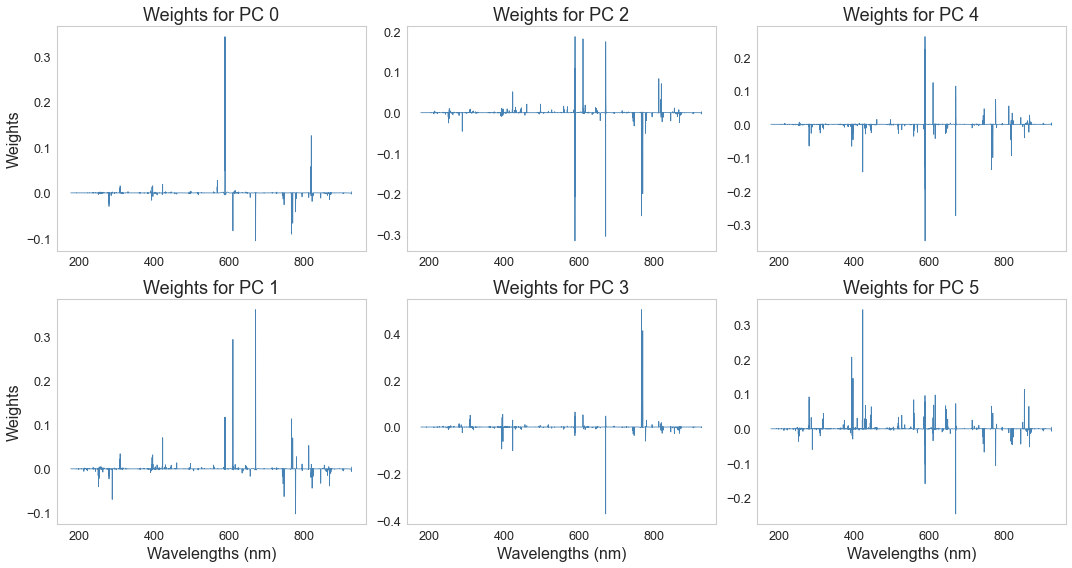

In [43]:
fig, ax = subplots(2, 3, figsize = (15, 8))

h, v = 0, 0

for i in range(principal_components.shape[-1]):
    axs = ax[h, v]
    axs.plot(wavelengths, weigths[i], color = 'steelblue', lw = 0.8)
    axs.set_title(f'Weights for PC {i}', fontsize = 18)
    axs.grid(False)

    if h == 1:
        axs.set_xlabel('Wavelengths (nm)', fontsize = 16) 
    if v == 0:
        axs.set_ylabel('Weights', fontsize = 16)
    
    h += 1
    if h == 2:
        v +=1
        h = 0

fig.tight_layout()